# Identifying Patterns And Trends In Campus Placement Data Using Machine Learning

## Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import pickle
import joblib

## Creating Dataset of Campus Placement

In [2]:
np.random.seed(42)

num_samples = 1650

data = {   
    'Student_ID': np.arange(20001, 20001 + num_samples),
    'Gender': np.random.choice(['Male', 'Female'], size=num_samples),
    'Age': np.random.randint(21, 31, size=num_samples),
    'Education': np.random.choice(['Bachelor', 'Master'], size=num_samples),
    'CGPA': np.round(np.random.uniform(5, 10, size=num_samples), 2),
    'Internships': np.random.randint(0, 5, size=num_samples),
    'Year': np.random.randint(2018, 2024, size=num_samples),
    'Hostel': np.random.choice(['Opted', 'Not Opted'], size=num_samples),
    'Projects' : np.random.randint(0, 6, size=num_samples),
    'Letter_of_Recommendation': np.random.choice(['Yes', 'No'], size=num_samples),
    'Specialization': np.random.choice(['Computer Science', 'Information Technology', 'Electrical', 'Electronics', 'Mechanical', 'Civil'], size=num_samples, p=[0.30, 0.20, 0.18, 0.17, 0.10, 0.05]),
    'On/Off Campus': np.random.choice(['On Campus', 'Off Campus'], size=num_samples),
    'Package(LPA)': np.random.randint(200000, 1000000, size=num_samples),
}

# Introduce missing values only for some features
missing_indices = np.random.choice(np.arange(num_samples), size=int(num_samples * 0.05), replace=False)
data['CGPA'][missing_indices] = np.nan

# Create DataFrame
df = pd.DataFrame(data)

# Set max age to 27 for bachelor's degree students
df.loc[(df['Education'] == "Bachelor") & (df['Age'] > 27), 'Age'] = 27

# Set min age to 24 for master's degree students
df.loc[(df['Education'] == "Master") & (df['Age'] < 24), 'Age'] = 24

# Add the 'HistoryOfBacklogs' column with random data
num_rows = df.shape[0]
df['HistoryOfBacklogs'] = np.random.randint(0, 5, size=num_rows)

# Add the 'Placement_Status' column with default 'Yes' values
df['Placement_Status'] = 'Placed'

# Update 'Placement_Status' based on conditions
df.loc[df['HistoryOfBacklogs'] > 2, 'Placement_Status'] = 'Not Placed'

# Modify the 'Package(LPA)' column to set salary to 0 for "Not Placed" category
df['Package(LPA)'] = np.where(df['Placement_Status'] == 'Not Placed', 0, df['Package(LPA)'])

# Save the dataset to CSV file
df.to_csv('campus_placement_dataset.csv', index=False)

print("Dataset created and saved as 'campus_placement_dataset.csv'")

Dataset created and saved as 'campus_placement_dataset.csv'


## Data Collection

In [3]:
#Load the dataset
df = pd.read_csv('campus_placement_dataset.csv')
df

Student_ID  Gender  Age Education  CGPA  Internships  Year     Hostel  \
0          20001    Male   26  Bachelor  9.14            0  2018      Opted   
1          20002  Female   24    Master  8.49            3  2022      Opted   
2          20003    Male   27  Bachelor  8.57            0  2019  Not Opted   
3          20004    Male   24    Master  7.31            3  2020      Opted   
4          20005    Male   24    Master  9.60            2  2019      Opted   
...          ...     ...  ...       ...   ...          ...   ...        ...   
1645       21646    Male   27  Bachelor  8.23            4  2022  Not Opted   
1646       21647    Male   27    Master  8.73            2  2021  Not Opted   
1647       21648  Female   21  Bachelor  6.16            0  2023      Opted   
1648       21649    Male   27  Bachelor  7.03            3  2021      Opted   
1649       21650  Female   25  Bachelor  6.35            1  2022      Opted   

      Projects Letter_of_Recommendation          Specialization On/Off Campus  \
0            0                      Yes              Electrical     On Campus   
1            2                       No              Electrical     On Campus   
2            4                       No        Computer Science    Off Campus   
3            5                      Yes        Computer Science     On Campus   
4            5                      Yes  Information Technology     On Campus   
...        ...                      ...                     ...           ...   
1645         4                      Yes        Computer Science     On Campus   
1646         4                      Yes             Electronics     On Campus   
1647         3                      Yes        Computer Science     On Campus   
1648         1                       No  Information Technology     On Campus   
1649         3                      Yes             Electronics    Off Campus   

      Package(LPA)  HistoryOfBacklogs Placement_Status  
0           815358                  0           Placed  
1           782456                  2           Placed  
2           270246                  2           Placed  
3                0                  4       Not Placed  
4                0                  3       Not Placed  
...            ...                ...              ...  
1645        348079                  1           Placed  
1646        563604                  2           Placed  
1647             0                  3       Not Placed  
1648        932224                  2           Placed  
1649        596605                  1           Placed  

[1650 rows x 15 columns]

In [4]:
# Getting to know the shape of data  
df.shape  

(1650, 15)

In [5]:
# Showing the first 5 rows of the dataset  
df.head()  

Student_ID  Gender  Age Education  CGPA  Internships  Year     Hostel  \
0       20001    Male   26  Bachelor  9.14            0  2018      Opted   
1       20002  Female   24    Master  8.49            3  2022      Opted   
2       20003    Male   27  Bachelor  8.57            0  2019  Not Opted   
3       20004    Male   24    Master  7.31            3  2020      Opted   
4       20005    Male   24    Master  9.60            2  2019      Opted   

   Projects Letter_of_Recommendation          Specialization On/Off Campus  \
0         0                      Yes              Electrical     On Campus   
1         2                       No              Electrical     On Campus   
2         4                       No        Computer Science    Off Campus   
3         5                      Yes        Computer Science     On Campus   
4         5                      Yes  Information Technology     On Campus   

   Package(LPA)  HistoryOfBacklogs Placement_Status  
0        815358                  0           Placed  
1        782456                  2           Placed  
2        270246                  2           Placed  
3             0                  4       Not Placed  
4             0                  3       Not Placed

In [6]:
# Showing the last 10 rows of the dataset  
df.tail(10)

Student_ID  Gender  Age Education  CGPA  Internships  Year     Hostel  \
1640       21641  Female   25    Master   NaN            0  2022  Not Opted   
1641       21642    Male   24  Bachelor  6.03            4  2020  Not Opted   
1642       21643    Male   26  Bachelor  7.52            4  2018  Not Opted   
1643       21644  Female   26  Bachelor  6.56            0  2022      Opted   
1644       21645    Male   23  Bachelor  7.14            1  2020  Not Opted   
1645       21646    Male   27  Bachelor  8.23            4  2022  Not Opted   
1646       21647    Male   27    Master  8.73            2  2021  Not Opted   
1647       21648  Female   21  Bachelor  6.16            0  2023      Opted   
1648       21649    Male   27  Bachelor  7.03            3  2021      Opted   
1649       21650  Female   25  Bachelor  6.35            1  2022      Opted   

      Projects Letter_of_Recommendation          Specialization On/Off Campus  \
1640         5                       No        Computer Science     On Campus   
1641         5                       No             Electronics     On Campus   
1642         4                      Yes              Electrical    Off Campus   
1643         2                      Yes              Electrical    Off Campus   
1644         5                       No        Computer Science     On Campus   
1645         4                      Yes        Computer Science     On Campus   
1646         4                      Yes             Electronics     On Campus   
1647         3                      Yes        Computer Science     On Campus   
1648         1                       No  Information Technology     On Campus   
1649         3                      Yes             Electronics    Off Campus   

      Package(LPA)  HistoryOfBacklogs Placement_Status  
1640             0                  3       Not Placed  
1641             0                  3       Not Placed  
1642             0                  3       Not Placed  
1643        691135                  1           Placed  
1644             0                  4       Not Placed  
1645        348079                  1           Placed  
1646        563604                  2           Placed  
1647             0                  3       Not Placed  
1648        932224                  2           Placed  
1649        596605                  1           Placed

In [7]:
# Showing 4 rows of the dataset at random  
df.sample(4)  

Student_ID  Gender  Age Education  CGPA  Internships  Year     Hostel  \
503        20504  Female   25    Master  6.87            0  2023      Opted   
386        20387    Male   24    Master  9.54            3  2022  Not Opted   
1641       21642    Male   24  Bachelor  6.03            4  2020  Not Opted   
561        20562    Male   26    Master  5.34            1  2018  Not Opted   

      Projects Letter_of_Recommendation Specialization On/Off Campus  \
503          0                      Yes     Electrical     On Campus   
386          3                       No    Electronics     On Campus   
1641         5                       No    Electronics     On Campus   
561          3                       No     Mechanical    Off Campus   

      Package(LPA)  HistoryOfBacklogs Placement_Status  
503         853980                  0           Placed  
386              0                  4       Not Placed  
1641             0                  3       Not Placed  
561         502295                  0           Placed

In [8]:
# Getting to know the data type of columns that are in the dataset  
df.dtypes 

Student_ID                    int64
Gender                       object
Age                           int64
Education                    object
CGPA                        float64
Internships                   int64
Year                          int64
Hostel                       object
Projects                      int64
Letter_of_Recommendation     object
Specialization               object
On/Off Campus                object
Package(LPA)                  int64
HistoryOfBacklogs             int64
Placement_Status             object
dtype: object

In [9]:
# Getting to know the detailed information of the columns  
df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650 entries, 0 to 1649
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Student_ID                1650 non-null   int64  
 1   Gender                    1650 non-null   object 
 2   Age                       1650 non-null   int64  
 3   Education                 1650 non-null   object 
 4   CGPA                      1568 non-null   float64
 5   Internships               1650 non-null   int64  
 6   Year                      1650 non-null   int64  
 7   Hostel                    1650 non-null   object 
 8   Projects                  1650 non-null   int64  
 9   Letter_of_Recommendation  1650 non-null   object 
 10  Specialization            1650 non-null   object 
 11  On/Off Campus             1650 non-null   object 
 12  Package(LPA)              1650 non-null   int64  
 13  HistoryOfBacklogs         1650 non-null   int64  
 14  Placemen

In [10]:
# Statistical Descriptions of the numerical values in the dataset  
df.describe()  

Student_ID          Age         CGPA  Internships         Year  \
count   1650.000000  1650.000000  1568.000000  1650.000000  1650.000000   
mean   20825.500000    25.468485     7.463909     1.970303  2020.458788   
std      476.458288     2.206839     1.423278     1.419253     1.723398   
min    20001.000000    21.000000     5.000000     0.000000  2018.000000   
25%    20413.250000    24.000000     6.230000     1.000000  2019.000000   
50%    20825.500000    25.000000     7.460000     2.000000  2020.000000   
75%    21237.750000    27.000000     8.652500     3.000000  2022.000000   
max    21650.000000    30.000000    10.000000     4.000000  2023.000000   

          Projects   Package(LPA)  HistoryOfBacklogs  
count  1650.000000    1650.000000        1650.000000  
mean      2.540606  358958.805455           1.949697  
std       1.674874  338516.465674           1.427620  
min       0.000000       0.000000           0.000000  
25%       1.000000       0.000000           1.000000  
50%       3.000000  339105.000000           2.000000  
75%       4.000000  657453.750000           3.000000  
max       5.000000  999083.000000           4.000000

## Data Preprocessing

In [11]:
# missing values  
df.isna().sum()  

Student_ID                   0
Gender                       0
Age                          0
Education                    0
CGPA                        82
Internships                  0
Year                         0
Hostel                       0
Projects                     0
Letter_of_Recommendation     0
Specialization               0
On/Off Campus                0
Package(LPA)                 0
HistoryOfBacklogs            0
Placement_Status             0
dtype: int64

In [12]:
# Group by education level and specialization and fill missing CGPA with the median CGPA of the group
df['CGPA'] = df.groupby(['Education', 'Specialization'])['CGPA'].transform(lambda x: x.fillna(x.median()))

In [13]:
df.isna().sum() 

Student_ID                  0
Gender                      0
Age                         0
Education                   0
CGPA                        0
Internships                 0
Year                        0
Hostel                      0
Projects                    0
Letter_of_Recommendation    0
Specialization              0
On/Off Campus               0
Package(LPA)                0
HistoryOfBacklogs           0
Placement_Status            0
dtype: int64

In [14]:
# duplicate rows  
df.duplicated().sum()  

0

In [15]:
#drop duplicates  
df.drop_duplicates(inplace=True)  

In [16]:
# Check if the duplicate rows are removed  
df.duplicated().sum()

0

## EDA

In [17]:
# Getting to know the correlation between the target column and other features.  
df.corr(numeric_only=True)

Student_ID       Age      CGPA  Internships      Year  \
Student_ID           1.000000  0.023542 -0.015044     0.016329  0.007453   
Age                  0.023542  1.000000  0.012074    -0.068937  0.044065   
CGPA                -0.015044  0.012074  1.000000     0.029776 -0.001762   
Internships          0.016329 -0.068937  0.029776     1.000000 -0.007319   
Year                 0.007453  0.044065 -0.001762    -0.007319  1.000000   
Projects             0.056104 -0.011467 -0.033724     0.010074  0.027052   
Package(LPA)         0.064906  0.010398  0.000478     0.000340  0.010757   
HistoryOfBacklogs   -0.066238 -0.004642  0.006904     0.019315  0.000759   

                   Projects  Package(LPA)  HistoryOfBacklogs  
Student_ID         0.056104      0.064906          -0.066238  
Age               -0.011467      0.010398          -0.004642  
CGPA              -0.033724      0.000478           0.006904  
Internships        0.010074      0.000340           0.019315  
Year               0.027052      0.010757           0.000759  
Projects           1.000000      0.017030          -0.003076  
Package(LPA)       0.017030      1.000000          -0.738640  
HistoryOfBacklogs -0.003076     -0.738640           1.000000

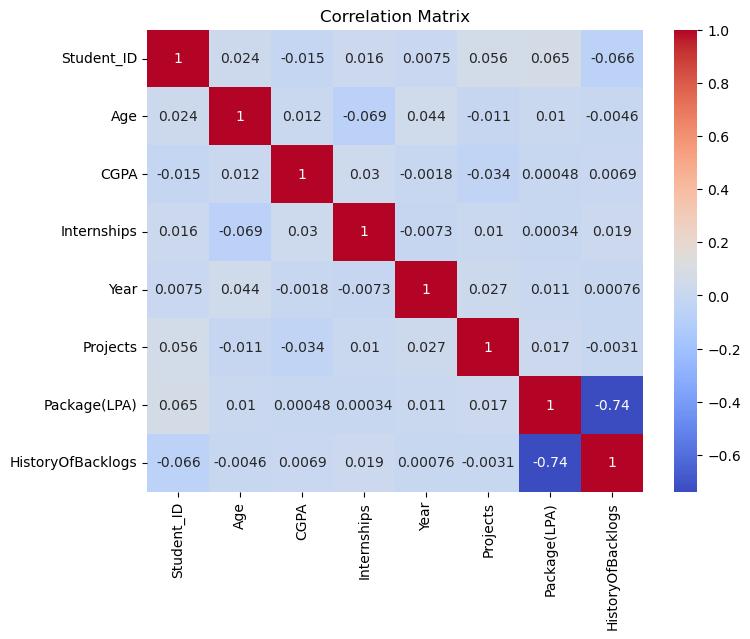

In [18]:
# Correlation matrix to visualize the correlation between variables
plt.figure(figsize=(8, 6))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [19]:
# Plotting  the graph so that we can visualize the output with respect to major features  
figure = px.scatter(df, x="CGPA", y="Internships", color="Placement_Status", color_discrete_map={"Placed": "green", "Not Placed": "red"}, hover_data=['CGPA'])  
figure.show() 

In [20]:
fig = px.box(df, x="Placement_Status", y="HistoryOfBacklogs",color="Placement_Status",color_discrete_map={"Placed": "green", "Not Placed": "red"}, title="Box Plot of Placement Status by History of Backlogs")
fig.show()

In [21]:
fig = px.box(df, x="Education", y="CGPA", title="Box and Violin Plot of CGPA by Education")
fig.update_traces(boxpoints="all", jitter=0.3, pointpos=-1.8)  
fig.show()

In [22]:
# Plotting Histogram for the count of place and not placed  
px.histogram(df, x='Placement_Status', color='Placement_Status',color_discrete_map={"Placed": "green", "Not Placed": "red"}, barmode='group')  

In [23]:
# Pie Chart: Percentage pie chart of Placed or Not Placed  
figure = px.pie(df, values=df['Placement_Status'].value_counts().values, names=df['Placement_Status'].value_counts().index, title='Placed Vs Not Placed')  
figure.show()  

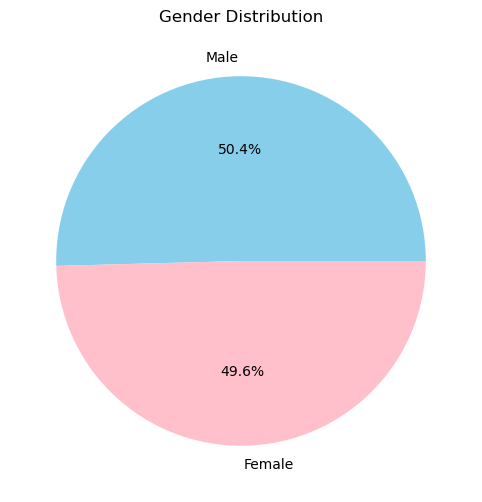

In [24]:
# Pie chart for Gender distribution
plt.figure(figsize=(8, 6))
gender_counts = df['Gender'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['skyblue', 'pink'])
plt.title("Gender Distribution")
plt.show()

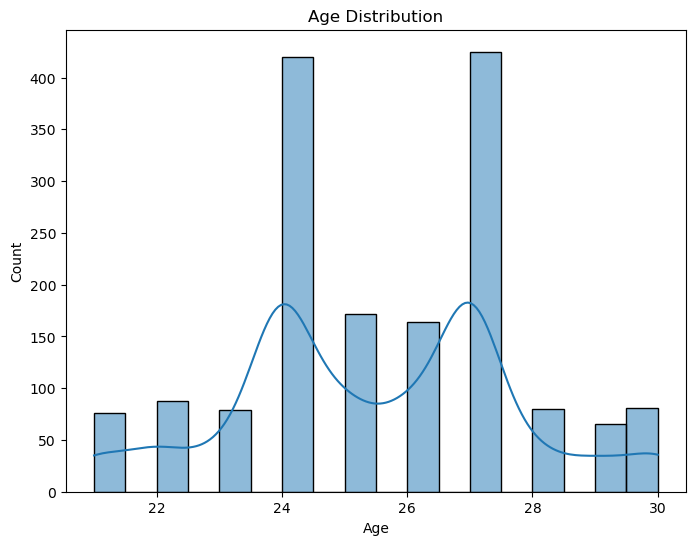

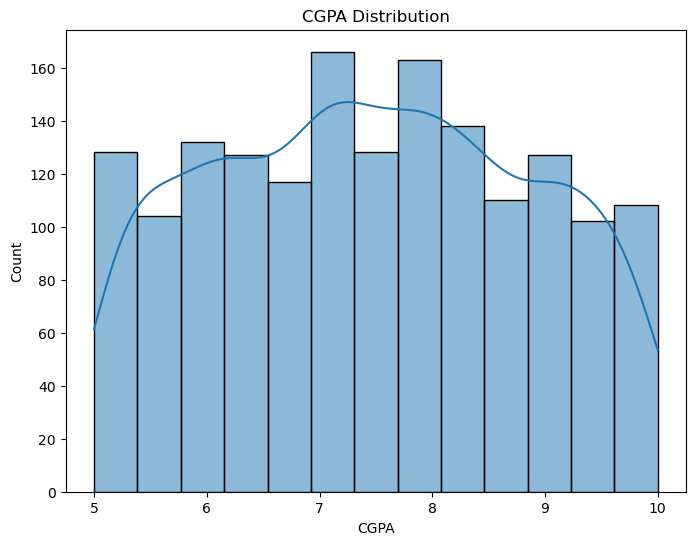

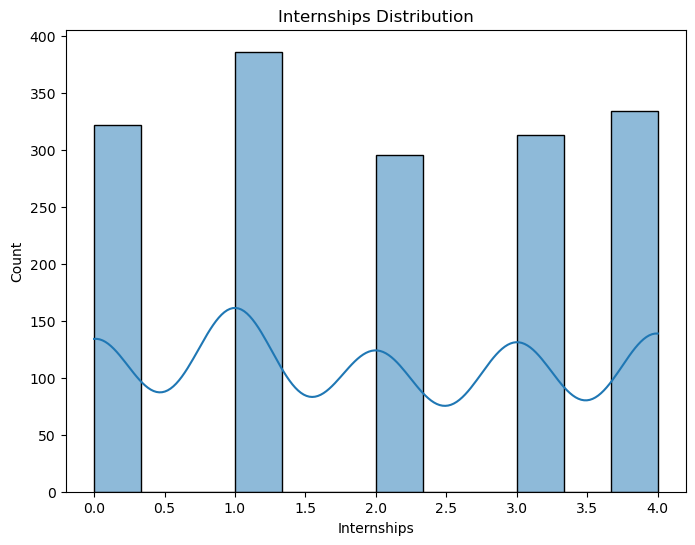

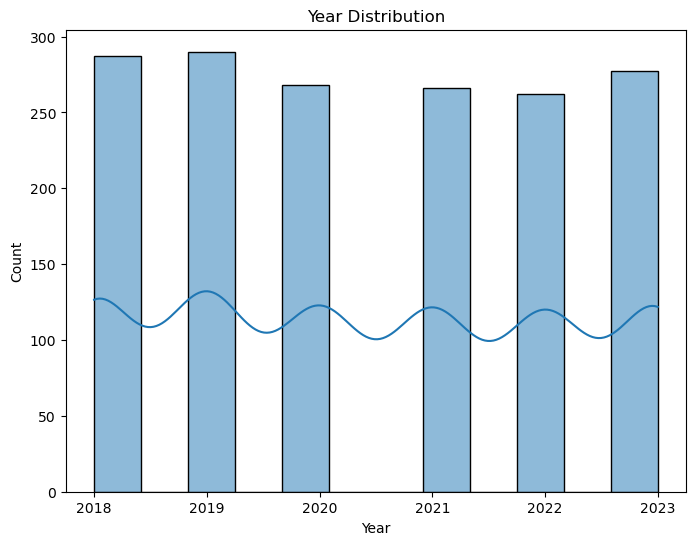

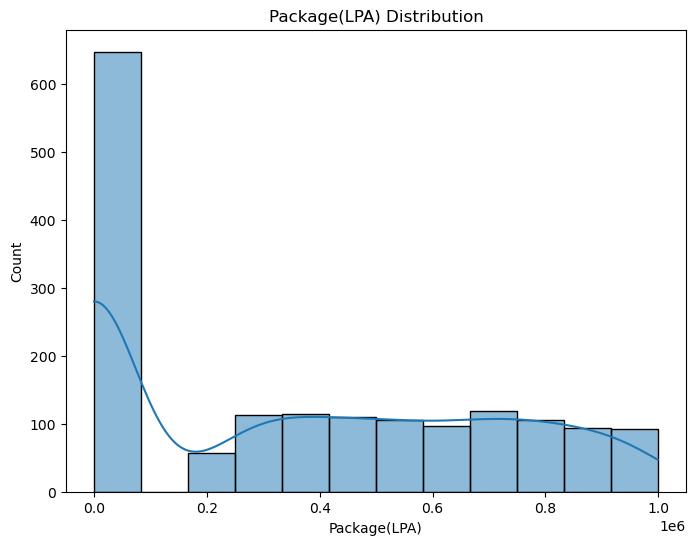

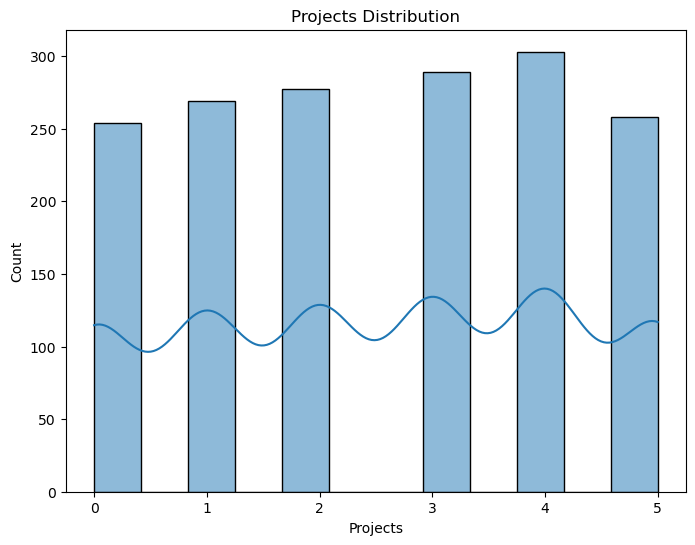

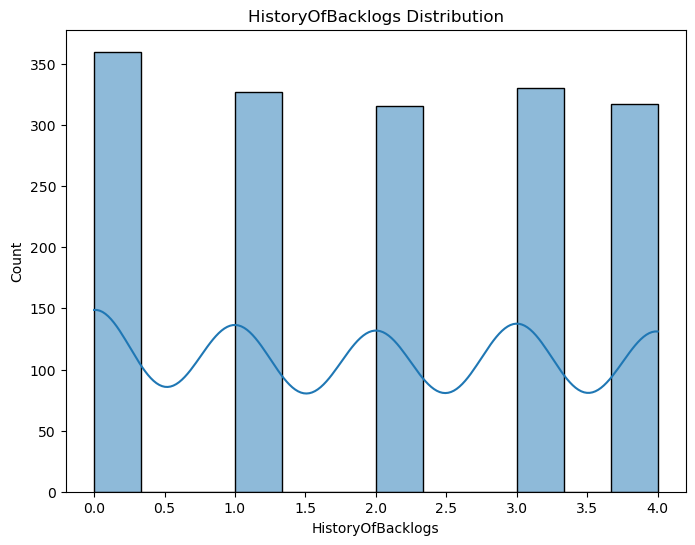

In [25]:
# Histogram for Numeric varibles

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='Age', kde=True)
plt.title("Age Distribution")
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="CGPA", kde=True)
plt.title("CGPA Distribution")
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="Internships", kde=True)
plt.title("Internships Distribution")
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="Year", kde=True)
plt.title("Year Distribution")
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="Package(LPA)", kde=True)
plt.title("Package(LPA) Distribution")
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="Projects", kde=True)
plt.title("Projects Distribution")
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="HistoryOfBacklogs", kde=True)
plt.title("HistoryOfBacklogs Distribution")
plt.show()

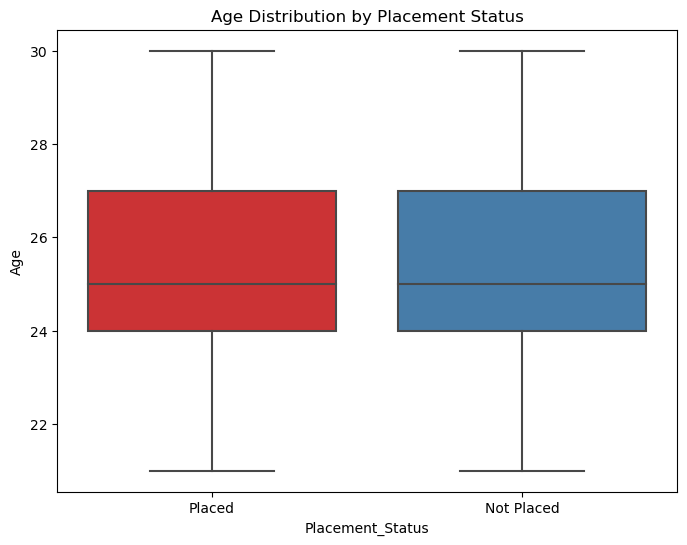

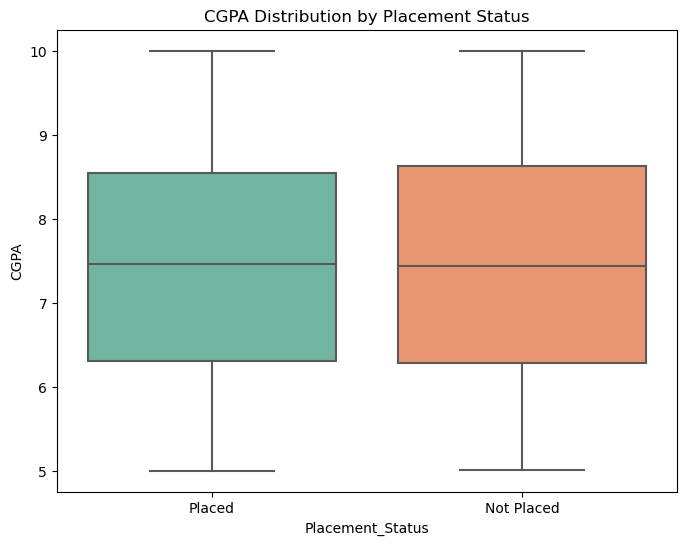

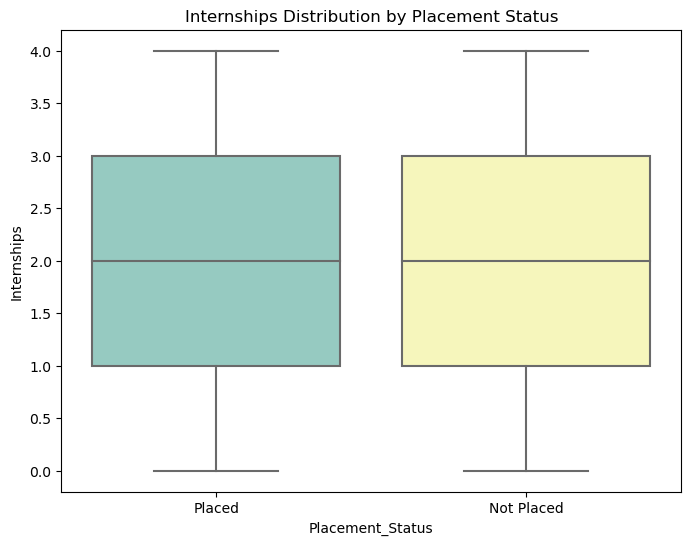

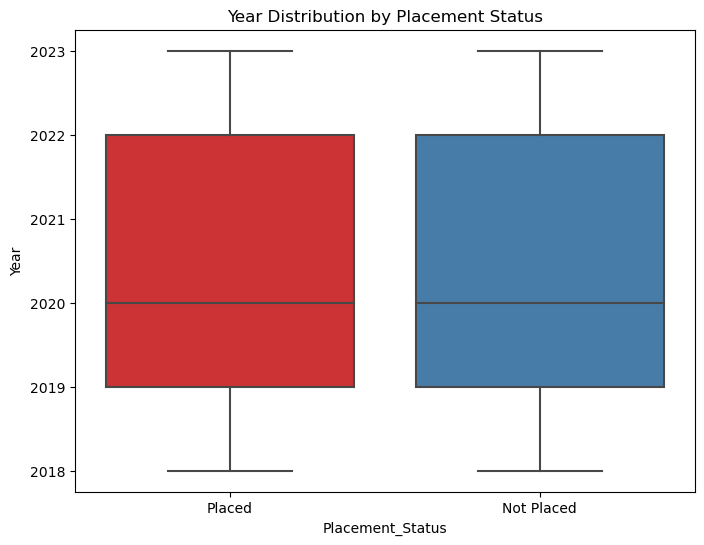

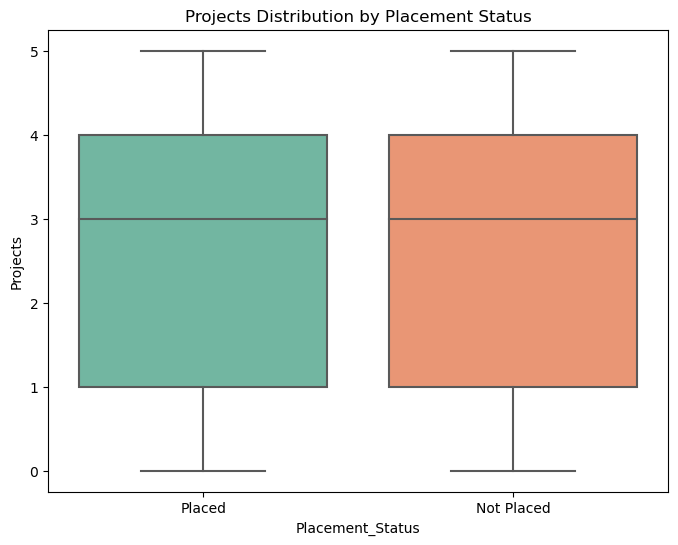

In [26]:
# Box plot for Numeric varibles by Placement_Status
plt.figure(figsize=(8, 6))
sns.boxplot(x="Placement_Status", y="Age", data=df, palette='Set1')
plt.title("Age Distribution by Placement Status")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x="Placement_Status", y="CGPA", data=df, palette='Set2')
plt.title("CGPA Distribution by Placement Status")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x="Placement_Status", y="Internships", data=df, palette='Set3')
plt.title("Internships Distribution by Placement Status")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x="Placement_Status", y="Year", data=df, palette='Set1')
plt.title("Year Distribution by Placement Status")
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(x="Placement_Status", y="Projects", data=df, palette='Set2')
plt.title("Projects Distribution by Placement Status")
plt.show()

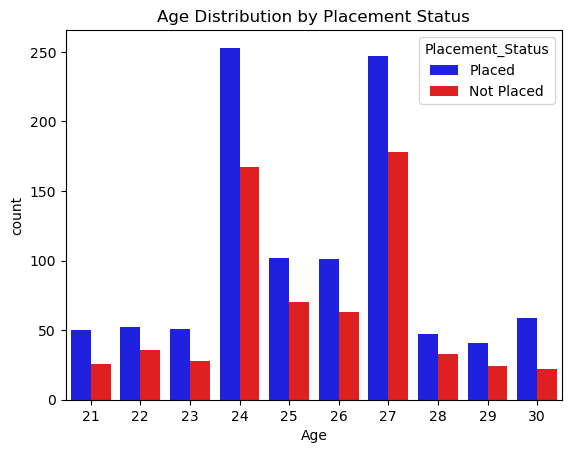

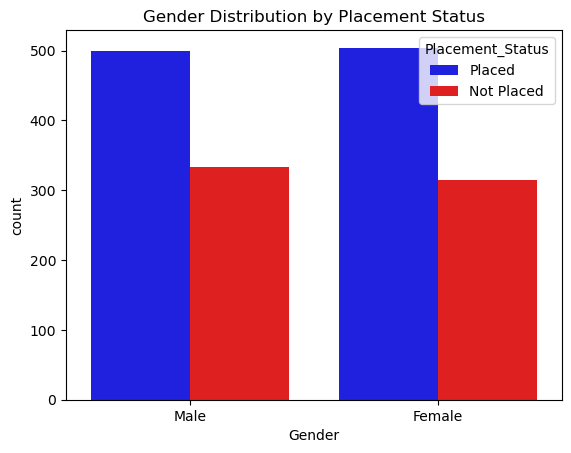

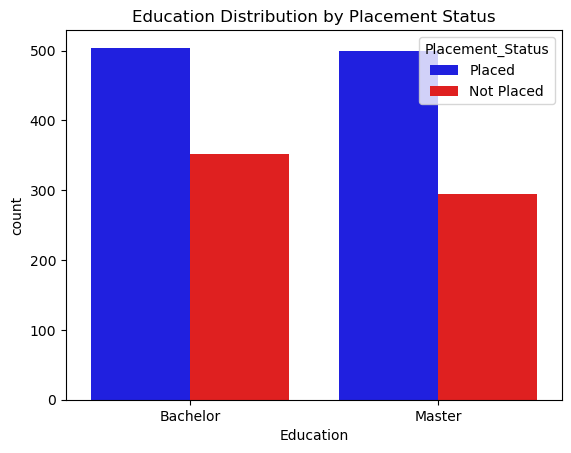

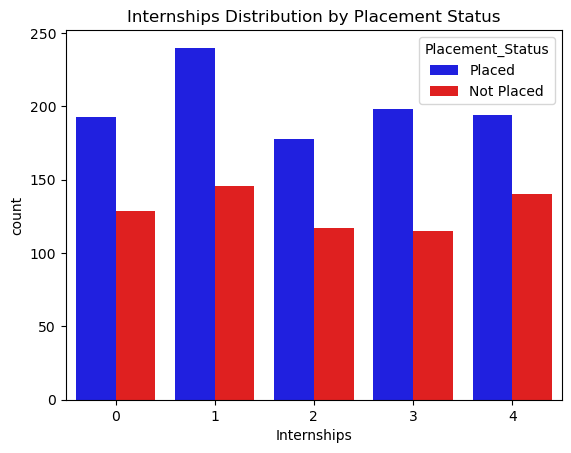

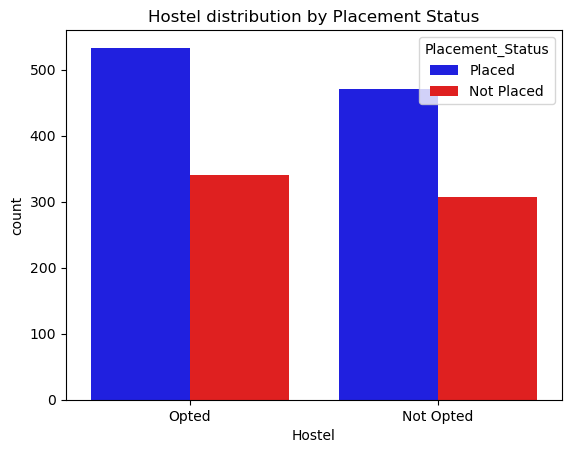

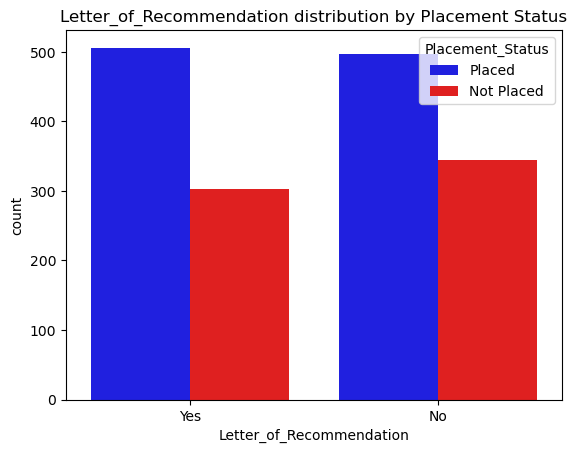

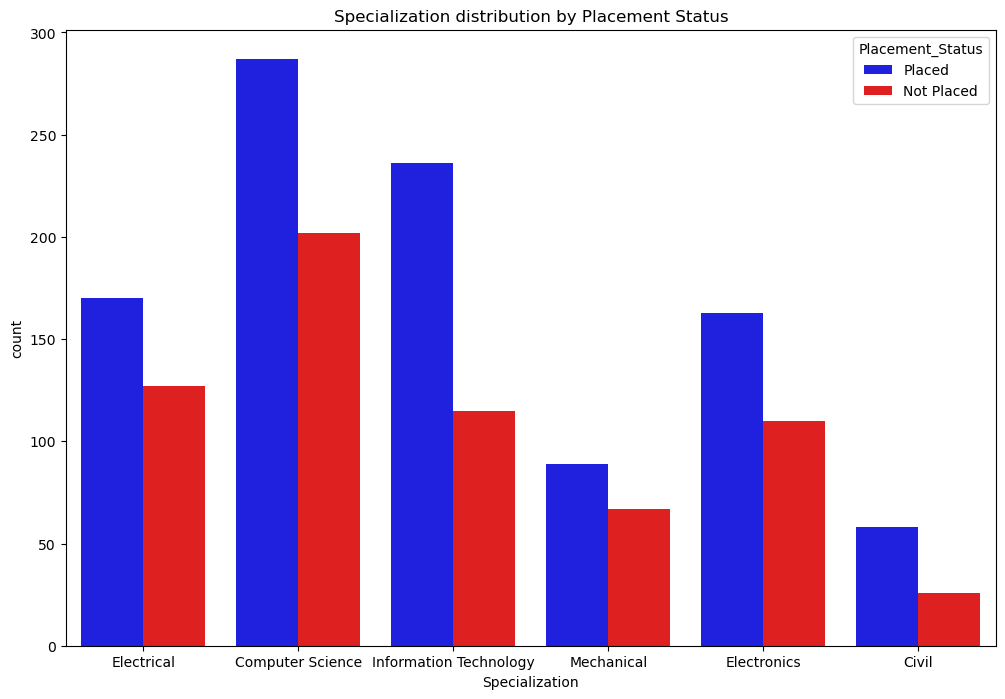

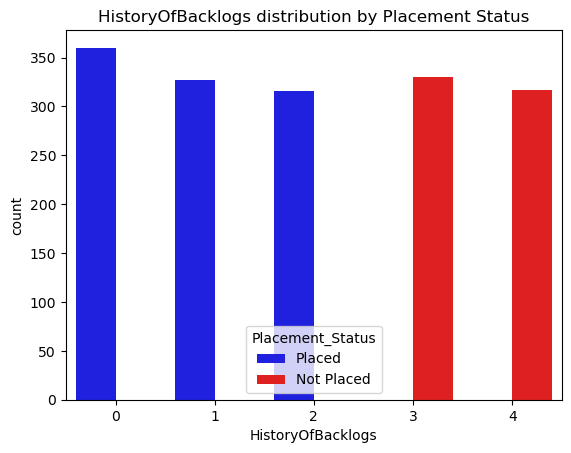

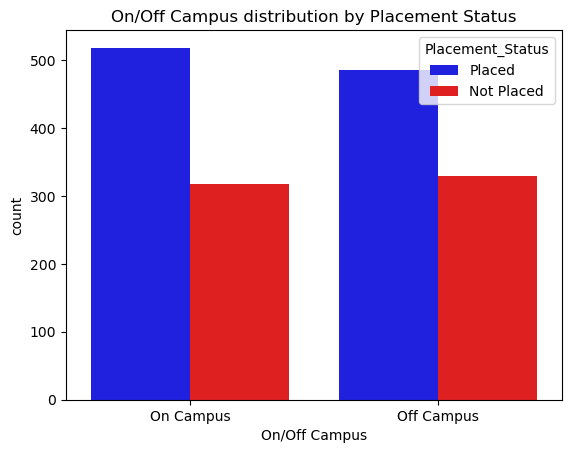

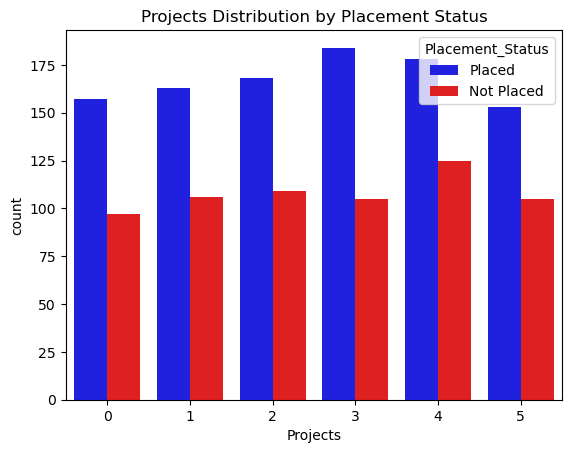

In [27]:
colors={"Placed": "blue", "Not Placed": "red"}
sns.countplot(x="Age", hue="Placement_Status", data=df, palette=colors)
plt.title("Age Distribution by Placement Status")
plt.show()
sns.countplot(x="Gender", hue="Placement_Status", data=df, palette=colors)
plt.title("Gender Distribution by Placement Status")
plt.show()
sns.countplot(x="Education", hue="Placement_Status", data=df, palette=colors)
plt.title("Education Distribution by Placement Status")
plt.show()
sns.countplot(x="Internships", hue="Placement_Status", data=df, palette=colors)
plt.title("Internships Distribution by Placement Status")
plt.show()
sns.countplot(x="Hostel", hue="Placement_Status", data=df, palette=colors)
plt.title("Hostel distribution by Placement Status")
plt.show()
sns.countplot(x="Letter_of_Recommendation", hue="Placement_Status", data=df, palette=colors)
plt.title("Letter_of_Recommendation distribution by Placement Status")
plt.show()
plt.figure(figsize=(12, 8))
sns.countplot(x="Specialization", hue="Placement_Status", data=df, palette=colors)
plt.title("Specialization distribution by Placement Status")
plt.show()
sns.countplot(x="HistoryOfBacklogs", hue="Placement_Status", data=df, palette=colors)
plt.title("HistoryOfBacklogs distribution by Placement Status")
plt.show()
sns.countplot(x="On/Off Campus", hue="Placement_Status", data=df, palette=colors)
plt.title("On/Off Campus distribution by Placement Status")
plt.show()
sns.countplot(x="Projects", hue="Placement_Status", data=df, palette=colors)
plt.title("Projects Distribution by Placement Status")
plt.show()

<Figure size 800x600 with 0 Axes>

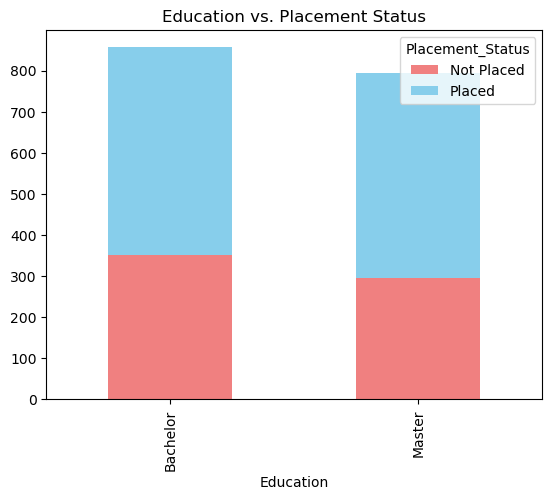

In [28]:
# Stacked bar chart for Education vs. Placement_Status
education_placement = df.groupby(['Education', 'Placement_Status']).size().unstack()
plt.figure(figsize=(8, 6))
education_placement.plot(kind='bar', stacked=True, color={"Placed": 'skyblue', "Not Placed": 'lightcoral'})
plt.title("Education vs. Placement Status")
plt.show()

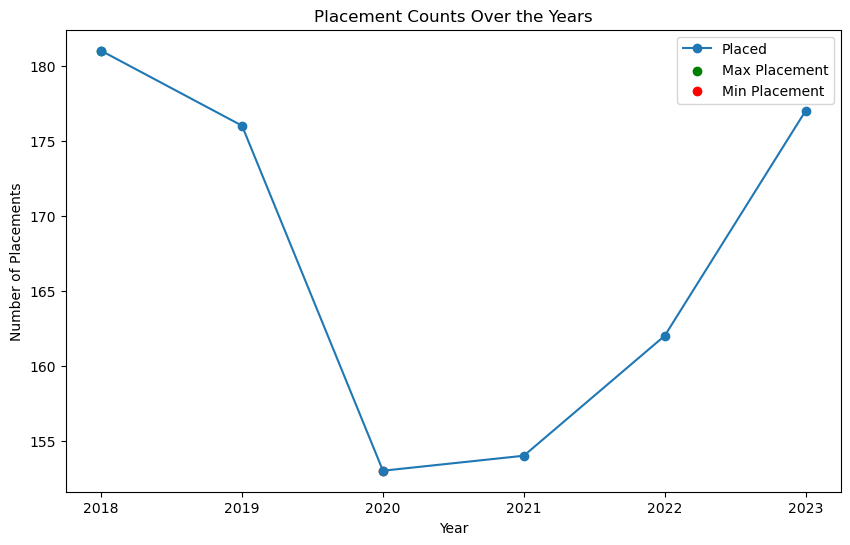

Year with the maximum placements: 2018
Year with the minimum placements: 2020


In [29]:
# Calculate maximum and minimum placement counts per year
placement_counts = df.groupby('Year')['Placement_Status'].value_counts().unstack()
max_placement_year = placement_counts['Placed'].idxmax()
min_placement_year = placement_counts['Placed'].idxmin()

# Plot maximum and minimum placement counts
plt.figure(figsize=(10, 6))
placement_counts['Placed'].plot(marker='o', label='Placed')
plt.scatter(max_placement_year, placement_counts['Placed'].max(), color='green', label='Max Placement')
plt.scatter(min_placement_year, placement_counts['Placed'].min(), color='red', label='Min Placement')
plt.title("Placement Counts Over the Years")
plt.xlabel("Year")
plt.ylabel("Number of Placements")
plt.legend()
plt.show()

print(f"Year with the maximum placements: {max_placement_year}")
print(f"Year with the minimum placements: {min_placement_year}")

<Figure size 1000x600 with 0 Axes>

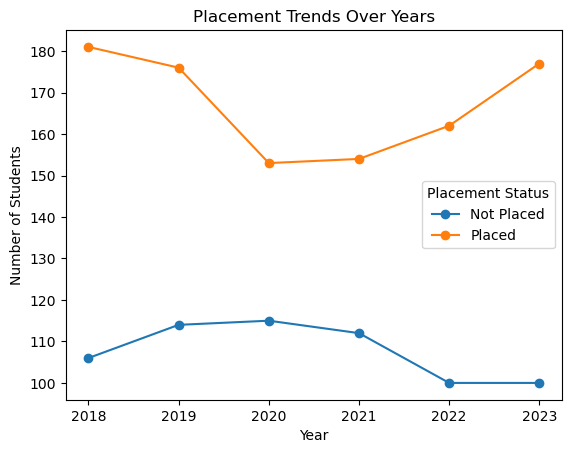

In [30]:
# Line chart for Placement trends over years
plt.figure(figsize=(10, 6))
placement_trends = df.groupby('Year')['Placement_Status'].value_counts().unstack().fillna(0)
placement_trends.plot(marker='o')
plt.title("Placement Trends Over Years")
plt.xlabel("Year")
plt.ylabel("Number of Students")
plt.legend(title="Placement Status")
plt.show()

In [31]:
# Filter placed students
placed_students = df[df['Placement_Status'] == 'Placed']

# Find the youngest and eldest placed students using the 'Age' column
youngest_student = placed_students.loc[placed_students['Age'].idxmin()]
eldest_student = placed_students.loc[placed_students['Age'].idxmax()]

# Print the results
print("Youngest Student:")
print(youngest_student)

print("\nEldest Student:")
print(eldest_student)

Youngest Student:
Student_ID                             20016
Gender                                  Male
Age                                       21
Education                           Bachelor
CGPA                                    7.48
Internships                                2
Year                                    2019
Hostel                                 Opted
Projects                                   1
Letter_of_Recommendation                 Yes
Specialization              Computer Science
On/Off Campus                      On Campus
Package(LPA)                          362187
HistoryOfBacklogs                          2
Placement_Status                      Placed
Name: 15, dtype: object

Eldest Student:
Student_ID                        20058
Gender                             Male
Age                                  30
Education                        Master
CGPA                               5.06
Internships                           0
Year                      

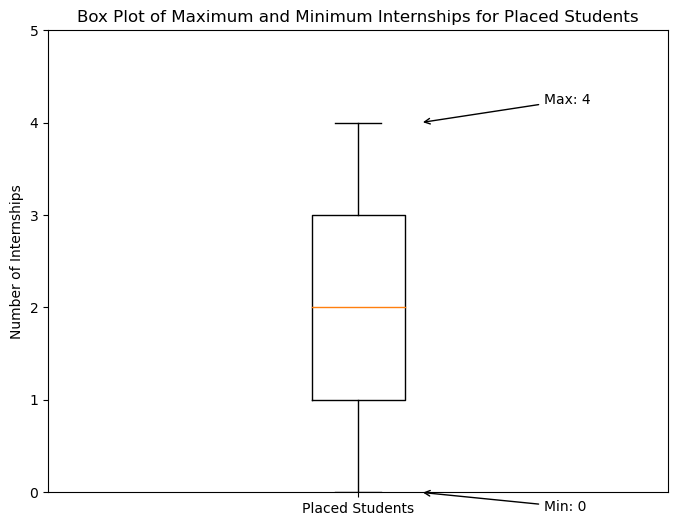

Maximum number of internships done by placed students:  4
Number of students who did the maximum internships:  0
Minimum number of internships done by placed students:  0
Number of students who did the minimum internships:  0


In [32]:
# Calculate maximum and minimum internships for placed students
max_internships = placed_students['Internships'].max()
min_internships = placed_students['Internships'].min()

# Set up Seaborn style
plt.figure(figsize=(8, 6))
plt.title('Box Plot of Maximum and Minimum Internships for Placed Students')

# Create a box plot
plt.boxplot([placed_students['Internships']], labels=['Placed Students'])
plt.ylabel('Number of Internships')
plt.ylim(0, 5)  # Set y-axis limit to better visualize the data

plt.annotate(f"Max: {max_internships}", xy=(1.1, max_internships), xytext=(1.3, max_internships + 0.2),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.annotate(f"Min: {min_internships}", xy=(1.1, min_internships), xytext=(1.3, min_internships - 0.2),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.show()

# Calculate the count of students with the maximum and minimum number of internships
count_max_internships = len(df[(df['Placement_Status'] == 'Yes') & (df['Internships'] == max_internships)])
count_min_internships = len(df[(df['Placement_Status'] == 'Yes') & (df['Internships'] == min_internships)])

# Print the results
print("Maximum number of internships done by placed students: ", max_internships)
print("Number of students who did the maximum internships: ", count_max_internships)
print("Minimum number of internships done by placed students: ", min_internships)
print("Number of students who did the minimum internships: ", count_min_internships)

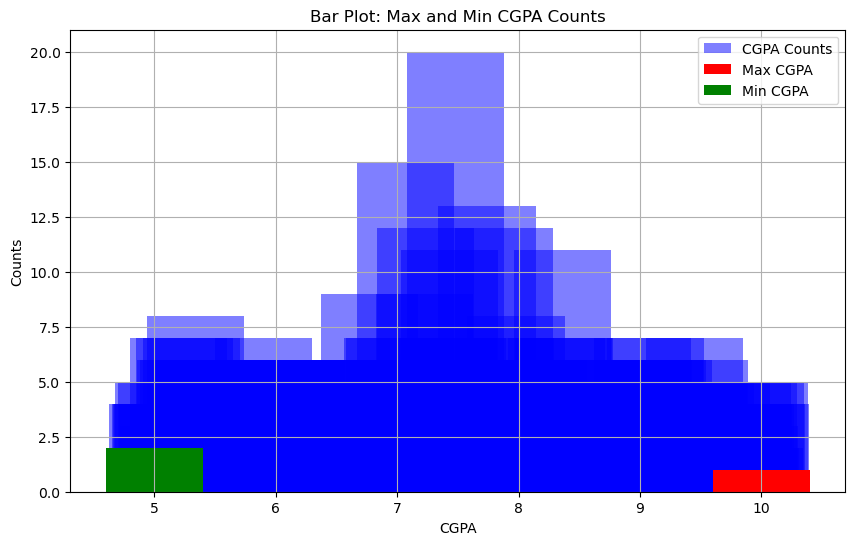

Maximum CGPA:  10.0
Number of students with maximum CGPA:  1
Minimum CGPA:  5.0
Number of students with minimum CGPA:  2


In [33]:
# Calculate the counts for each CGPA bin
cgpa_counts = df['CGPA'].value_counts().sort_index()

# Find the maximum and minimum CGPA values
max_cgpa = df['CGPA'].max()
min_cgpa = df['CGPA'].min()

# Set up Seaborn style
plt.figure(figsize=(10, 6))

# Create bar plot for CGPA counts
plt.bar(cgpa_counts.index, cgpa_counts.values, color='blue', alpha=0.5, label='CGPA Counts')

# Mark the maximum and minimum CGPA values with red color
plt.bar(max_cgpa, cgpa_counts[max_cgpa], color='red', label='Max CGPA')
plt.bar(min_cgpa, cgpa_counts[min_cgpa], color='green', label='Min CGPA')
plt.title('Bar Plot: Max and Min CGPA Counts')
plt.xlabel('CGPA')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.show()

# Count the number of students with maximum and minimum CGPA
count_max_cgpa = df[df['CGPA'] == max_cgpa].shape[0]
count_min_cgpa = df[df['CGPA'] == min_cgpa].shape[0]

# Print the results
print("Maximum CGPA: ", max_cgpa)
print("Number of students with maximum CGPA: ", count_max_cgpa)
print("Minimum CGPA: ", min_cgpa)
print("Number of students with minimum CGPA: ", count_min_cgpa)

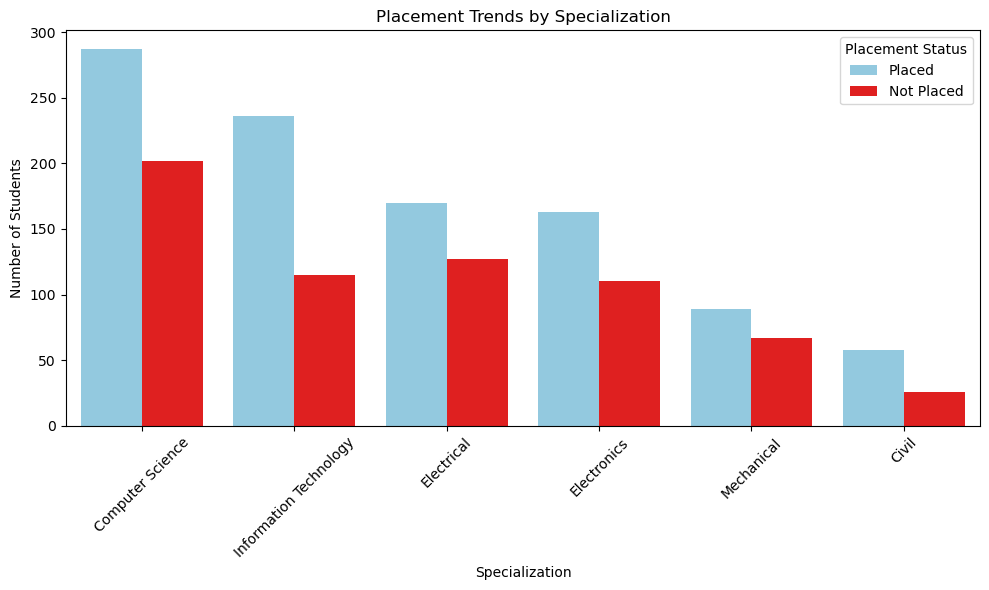

In [34]:
# Define the desired specialization order
specialization_order = ['Computer Science', 'Information Technology', 'Electrical', 'Electronics', 'Mechanical', 'Civil']

# Create a count plot for placement trends by specialization
plt.figure(figsize=(10, 6))
sns.countplot(x='Specialization', hue='Placement_Status', data=df, order=specialization_order, palette=['skyblue', 'red'])
plt.title('Placement Trends by Specialization')
plt.xlabel('Specialization')
plt.ylabel('Number of Students')
plt.legend(title='Placement Status')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

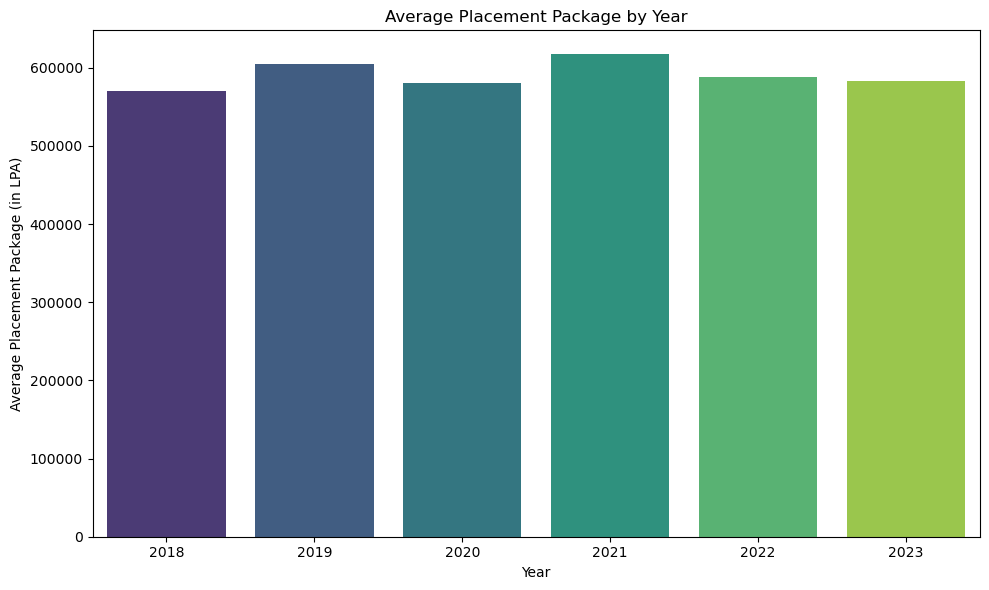

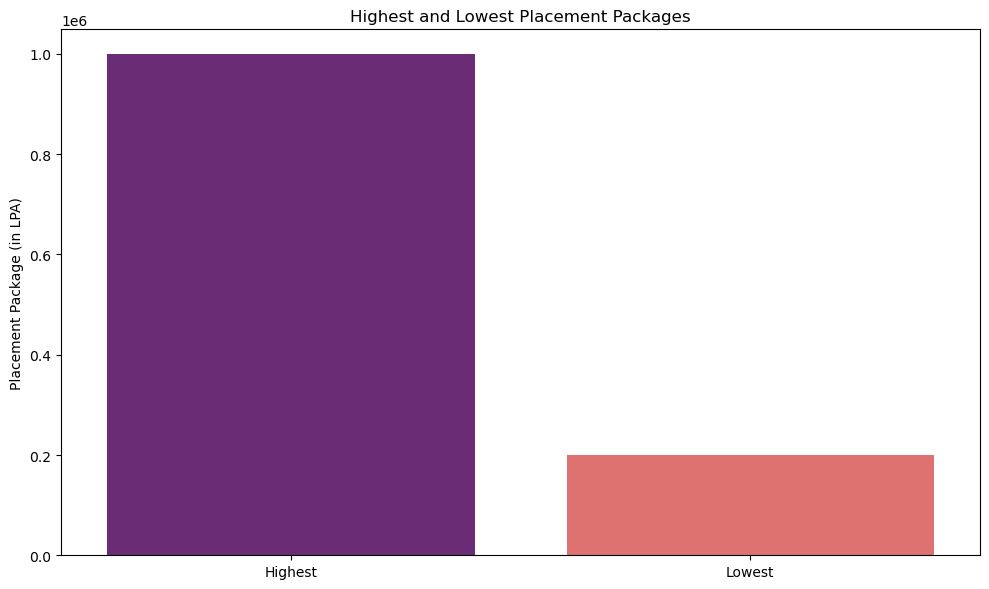

Average placement by year:
Year
2018    570828.182320
2019    605371.051136
2020    580909.679739
2021    617107.077922
2022    588139.450617
2023    583189.610169
Name: Package(LPA), dtype: float64

Highest placement:
Student_ID                       21242
Gender                          Female
Age                                 23
Education                     Bachelor
CGPA                              9.36
Internships                          1
Year                              2018
Hostel                           Opted
Projects                             1
Letter_of_Recommendation            No
Specialization              Electrical
On/Off Campus               Off Campus
Package(LPA)                    999083
HistoryOfBacklogs                    1
Placement_Status                Placed
Name: 1241, dtype: object

Lowest placement:
Student_ID                        20865
Gender                           Female
Age                                  24
Education                      

In [35]:
# Filter only placed students
placed_df = df[df['Placement_Status'] == 'Placed']

# Calculate average placement package by year
average_placement_by_year = placed_df.groupby('Year')['Package(LPA)'].mean()

# Find highest and lowest placement packages
highest_placement = placed_df.loc[placed_df['Package(LPA)'].idxmax()]
lowest_placement = placed_df.loc[placed_df['Package(LPA)'].idxmin()]

# Create a bar plot for average placement by year
plt.figure(figsize=(10, 6))
sns.barplot(x=average_placement_by_year.index, y=average_placement_by_year.values, palette='viridis')
plt.xlabel('Year')
plt.ylabel('Average Placement Package (in LPA)')
plt.title('Average Placement Package by Year')
plt.tight_layout()

# Display the plot
plt.show()

# Visualize the highest and lowest placement packages
plt.figure(figsize=(10, 6))
sns.barplot(x=['Highest', 'Lowest'], y=[highest_placement['Package(LPA)'], lowest_placement['Package(LPA)']], palette='magma')
plt.ylabel('Placement Package (in LPA)')
plt.title('Highest and Lowest Placement Packages')
plt.tight_layout()

# Display the plot
plt.show()

print("Average placement by year:")
print(average_placement_by_year)
print("\nHighest placement:")
print(highest_placement)
print("\nLowest placement:")
print(lowest_placement)

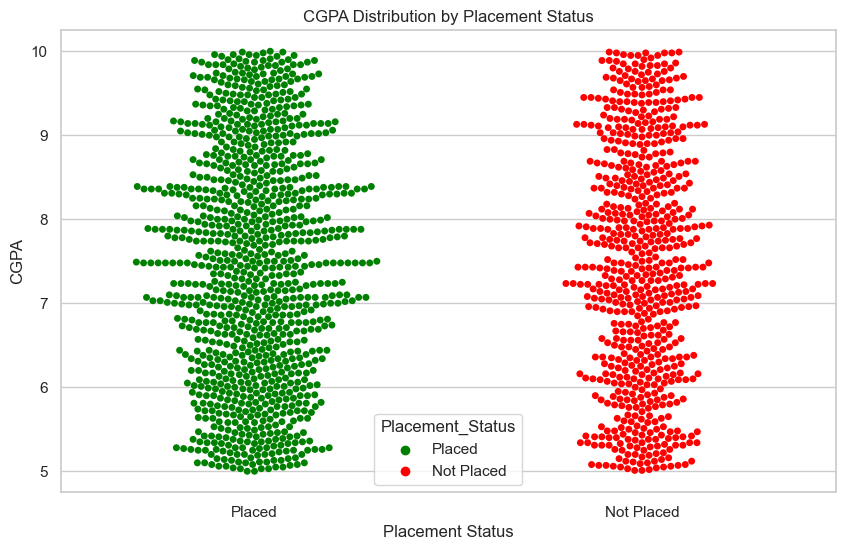

In [36]:
# Set up Seaborn style
sns.set(style="whitegrid")

# Create a swarm plot for CGPA by Placement_Status
plt.figure(figsize=(10, 6))
sns.swarmplot(x='Placement_Status', y='CGPA', data=df, hue='Placement_Status', palette={'Placed': 'green', 'Not Placed': 'red'})
plt.title("CGPA Distribution by Placement Status")
plt.xlabel("Placement Status")
plt.ylabel("CGPA")
plt.show()

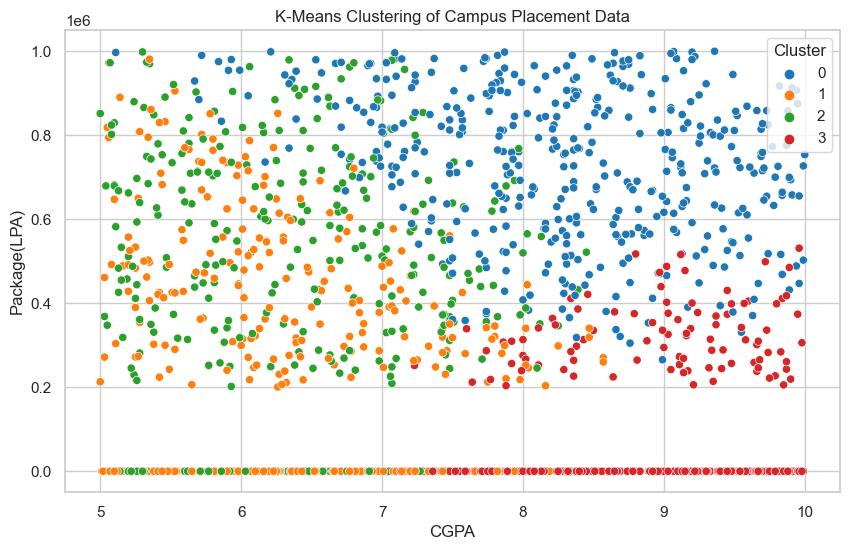

In [37]:
from sklearn.cluster import KMeans

# Select relevant attributes for clustering
attributes_for_clustering = ['Age', 'CGPA', 'Internships', 'Package(LPA)']

# Remove rows with missing values
df_cleaned = df.dropna(subset=attributes_for_clustering)

# Normalize the data
normalized_data = (df_cleaned[attributes_for_clustering] - df_cleaned[attributes_for_clustering].mean()) / df_cleaned[attributes_for_clustering].std()

# Perform K-Means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=42)
df_cleaned['Cluster'] = kmeans.fit_predict(normalized_data)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='CGPA', y='Package(LPA)', hue='Cluster', palette='tab10')
plt.title('K-Means Clustering of Campus Placement Data')
plt.xlabel('CGPA')
plt.ylabel('Package(LPA)')
plt.show()

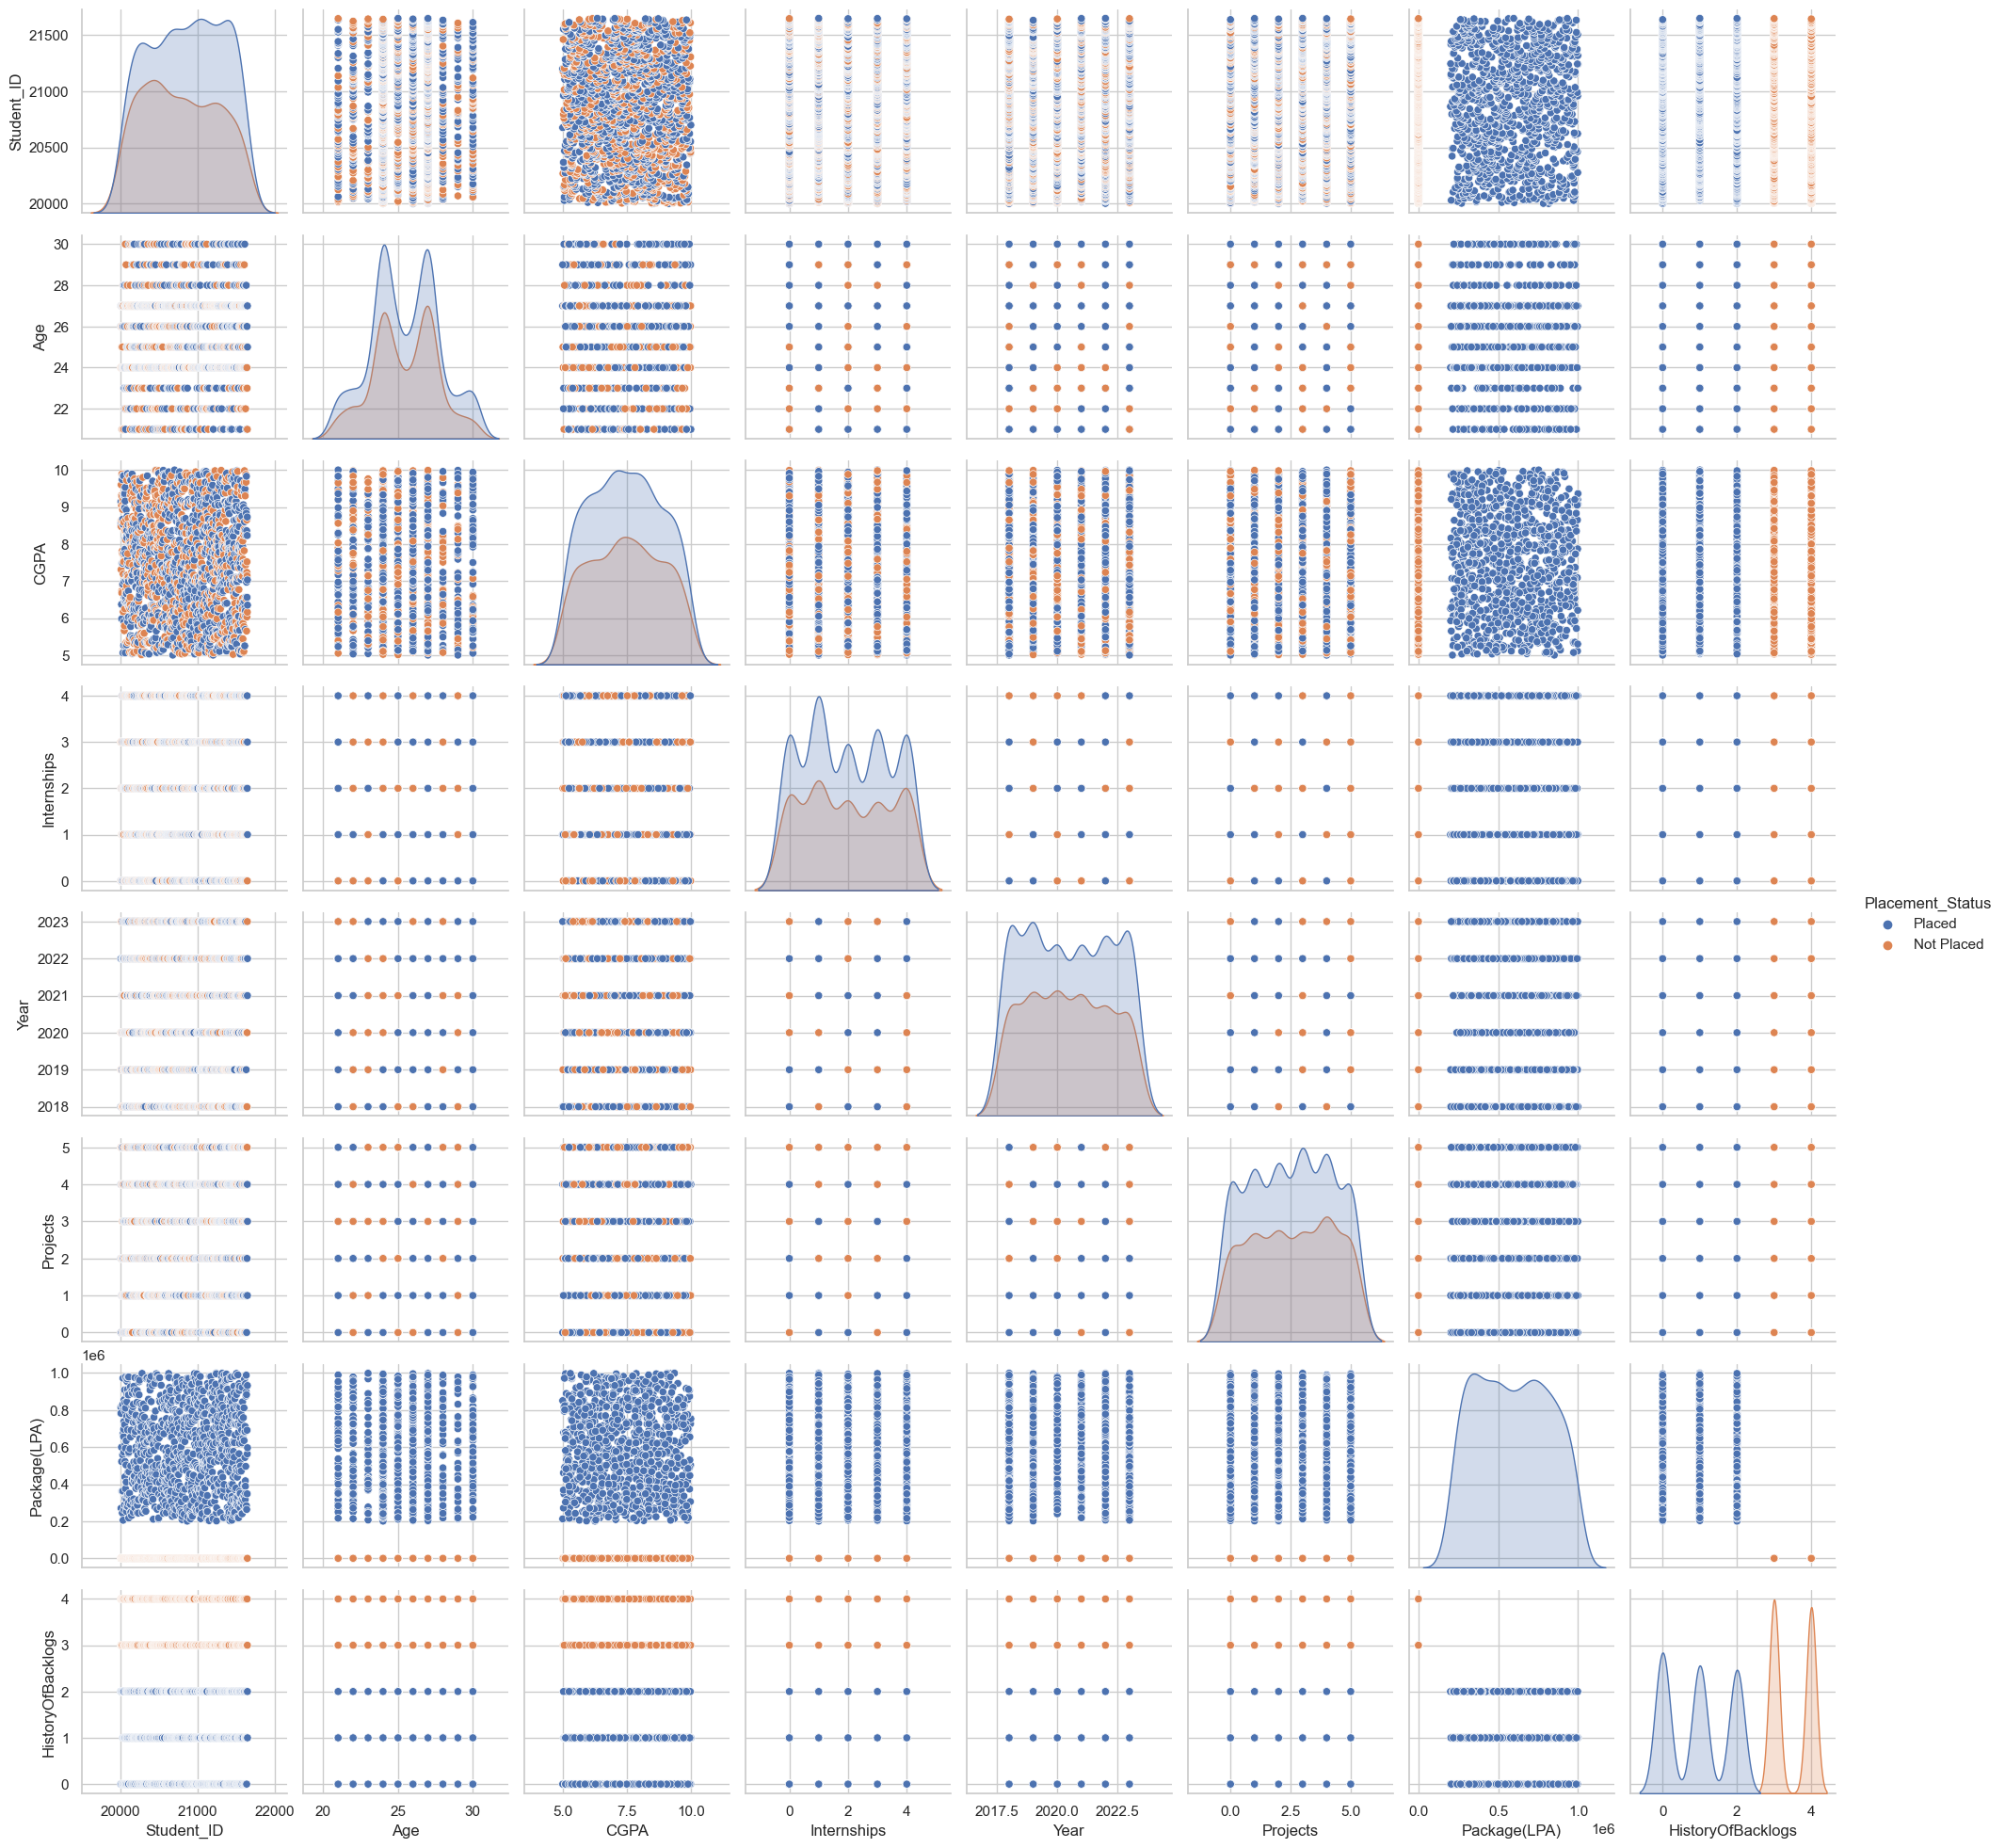

In [38]:
sns.pairplot(data=df, hue="Placement_Status")

## Feature Engineering:

In [39]:
df

Student_ID  Gender  Age Education  CGPA  Internships  Year     Hostel  \
0          20001    Male   26  Bachelor  9.14            0  2018      Opted   
1          20002  Female   24    Master  8.49            3  2022      Opted   
2          20003    Male   27  Bachelor  8.57            0  2019  Not Opted   
3          20004    Male   24    Master  7.31            3  2020      Opted   
4          20005    Male   24    Master  9.60            2  2019      Opted   
...          ...     ...  ...       ...   ...          ...   ...        ...   
1645       21646    Male   27  Bachelor  8.23            4  2022  Not Opted   
1646       21647    Male   27    Master  8.73            2  2021  Not Opted   
1647       21648  Female   21  Bachelor  6.16            0  2023      Opted   
1648       21649    Male   27  Bachelor  7.03            3  2021      Opted   
1649       21650  Female   25  Bachelor  6.35            1  2022      Opted   

      Projects Letter_of_Recommendation          Specialization On/Off Campus  \
0            0                      Yes              Electrical     On Campus   
1            2                       No              Electrical     On Campus   
2            4                       No        Computer Science    Off Campus   
3            5                      Yes        Computer Science     On Campus   
4            5                      Yes  Information Technology     On Campus   
...        ...                      ...                     ...           ...   
1645         4                      Yes        Computer Science     On Campus   
1646         4                      Yes             Electronics     On Campus   
1647         3                      Yes        Computer Science     On Campus   
1648         1                       No  Information Technology     On Campus   
1649         3                      Yes             Electronics    Off Campus   

      Package(LPA)  HistoryOfBacklogs Placement_Status  
0           815358                  0           Placed  
1           782456                  2           Placed  
2           270246                  2           Placed  
3                0                  4       Not Placed  
4                0                  3       Not Placed  
...            ...                ...              ...  
1645        348079                  1           Placed  
1646        563604                  2           Placed  
1647             0                  3       Not Placed  
1648        932224                  2           Placed  
1649        596605                  1           Placed  

[1650 rows x 15 columns]

In [40]:
# Convert categorical variables to numerical using LabelEncoder
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df['Education'] = le.fit_transform(df['Education'])
df['Hostel'] = le.fit_transform(df['Hostel'])
df['Letter_of_Recommendation'] = le.fit_transform(df['Letter_of_Recommendation'])
df['Specialization'] = le.fit_transform(df['Specialization'])
df['On/Off Campus'] = le.fit_transform(df['On/Off Campus'])
df['Placement_Status'] = le.fit_transform(df['Placement_Status'])

In [41]:
df.head(20)

Student_ID  Gender  Age  Education  CGPA  Internships  Year  Hostel  \
0        20001       1   26          0  9.14            0  2018       1   
1        20002       0   24          1  8.49            3  2022       1   
2        20003       1   27          0  8.57            0  2019       0   
3        20004       1   24          1  7.31            3  2020       1   
4        20005       1   24          1  9.60            2  2019       1   
5        20006       0   24          1  8.47            0  2019       0   
6        20007       1   24          1  8.64            2  2020       0   
7        20008       1   26          1  9.31            3  2023       1   
8        20009       1   27          0  6.37            2  2020       1   
9        20010       0   27          0  9.04            0  2019       1   
10       20011       1   27          0  5.98            0  2020       1   
11       20012       1   24          1  6.73            2  2023       0   
12       20013       1   26          0  6.68            1  2018       1   
13       20014       1   25          0  9.89            3  2020       1   
14       20015       0   27          0  9.28            3  2020       0   
15       20016       1   21          0  7.48            2  2019       1   
16       20017       0   21          0  8.64            1  2018       1   
17       20018       0   26          1  7.81            0  2021       0   
18       20019       0   27          0  9.74            4  2021       0   
19       20020       1   24          1  7.48            4  2022       1   

    Projects  Letter_of_Recommendation  Specialization  On/Off Campus  \
0          0                         1               2              1   
1          2                         0               2              1   
2          4                         0               1              0   
3          5                         1               1              1   
4          5                         1               4              1   
5          0                         0               1              0   
6          5                         0               5              1   
7          5                         1               1              0   
8          0                         0               4              1   
9          5                         1               1              1   
10         2                         1               1              0   
11         1                         0               2              0   
12         4                         0               2              0   
13         2                         0               1              0   
14         2                         0               1              1   
15         1                         1               1              1   
16         4                         0               3              1   
17         2                         0               2              0   
18         5                         0               1              1   
19         1                         1               4              1   

    Package(LPA)  HistoryOfBacklogs  Placement_Status  
0         815358                  0                 1  
1         782456                  2                 1  
2         270246                  2                 1  
3              0                  4                 0  
4              0                  3                 0  
5              0                  4                 0  
6              0                  4                 0  
7              0                  3                 0  
8         599325                  2                 1  
9              0                  3                 0  
10        521901                  0                 1  
11             0                  4                 0  
12             0                  4                 0  
13             0                  3                 0  
14             0                  4                 0 

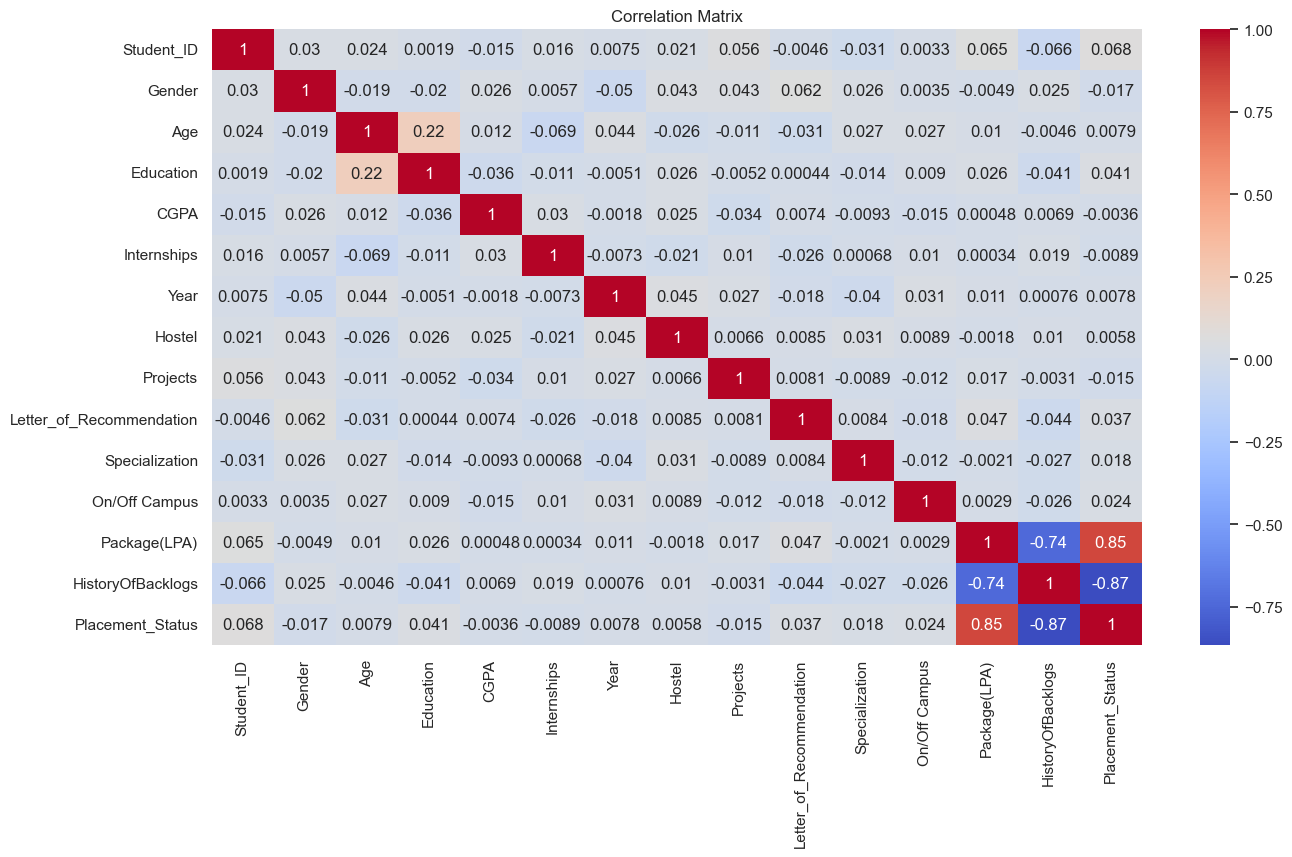

In [42]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [43]:
#Extracting Input and Output Columns
X = df.drop(['Year','Hostel','On/Off Campus','Package(LPA)','Placement_Status'], axis=1)
y = df['Placement_Status']  
X

Student_ID  Gender  Age  Education  CGPA  Internships  Projects  \
0          20001       1   26          0  9.14            0         0   
1          20002       0   24          1  8.49            3         2   
2          20003       1   27          0  8.57            0         4   
3          20004       1   24          1  7.31            3         5   
4          20005       1   24          1  9.60            2         5   
...          ...     ...  ...        ...   ...          ...       ...   
1645       21646       1   27          0  8.23            4         4   
1646       21647       1   27          1  8.73            2         4   
1647       21648       0   21          0  6.16            0         3   
1648       21649       1   27          0  7.03            3         1   
1649       21650       0   25          0  6.35            1         3   

      Letter_of_Recommendation  Specialization  HistoryOfBacklogs  
0                            1               2                  0  
1                            0               2                  2  
2                            0               1                  2  
3                            1               1                  4  
4                            1               4                  3  
...                        ...             ...                ...  
1645                         1               1                  1  
1646                         1               3                  2  
1647                         1               1                  3  
1648                         0               4                  2  
1649                         1               3                  1  

[1650 rows x 10 columns]

In [44]:
y

0       1
1       1
2       1
3       0
4       0
       ..
1645    1
1646    1
1647    0
1648    1
1649    1
Name: Placement_Status, Length: 1650, dtype: int32

In [45]:
# Getting the shape of the X and Y  
print(X.shape)  
print(y.shape)  

(1650, 10)
(1650,)


## Data Splitting

In [46]:
# Splitting the dataset into training and testing datasets.  
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)  

In [47]:
# Getting the Shape of all the training and testing dataset  
print(X_train.shape)  
print(X_test.shape)  
print(y_train.shape)  
print(y_test.shape)  

(1105, 10)
(545, 10)
(1105,)
(545,)


## Model Training

In [48]:
from sklearn.linear_model import LogisticRegression
logreg= LogisticRegression(max_iter=1000, random_state=42)  
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## Model Evalution

In [49]:
y_pred= logreg.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
Confusion Matrix:
 [[208   0]
 [  0 337]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       208
           1       1.00      1.00      1.00       337

    accuracy                           1.00       545
   macro avg       1.00      1.00      1.00       545
weighted avg       1.00      1.00      1.00       545



## Prediction

In [50]:
print("Accuracy Score for Test Dataset is ",logreg.score(X_test, y_test)*100,"%")
print("Accuracy Score for Train Dataset is",logreg.score(X_train,y_train)*100,"%")

Accuracy Score for Test Dataset is  100.0 %
Accuracy Score for Train Dataset is 100.0 %


## Scaling

In [51]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Hypermeter Tuning

In [52]:
param_grid = {
    'penalty': ['l2'],  # L2 regularization
    'C': [0.001, 0.01, 0.1, 1, 10]  # Inverse of regularization strength
}

# Perform hyperparameter tuning using GridSearchCV with cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_logreg = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_logreg.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
best_params = grid_search.best_params_

print(f"Best hyperparameters: {best_params}")
print(f"Accuracy on test set: {accuracy:.2f}")

Best hyperparameters: {'C': 0.01, 'penalty': 'l2'}
Accuracy on test set: 1.00


In [53]:
model = LogisticRegression(C=0.001, penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=0.001, max_iter=1000, random_state=42)

In [54]:
y_pred= model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_rep)

Accuracy: 0.8770642201834863
Precision: 0.8341584158415841
Recall: 1.0
F1-Score: 0.9095816464237516
Confusion Matrix:
 [[141  67]
 [  0 337]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.68      0.81       208
           1       0.83      1.00      0.91       337

    accuracy                           0.88       545
   macro avg       0.92      0.84      0.86       545
weighted avg       0.90      0.88      0.87       545



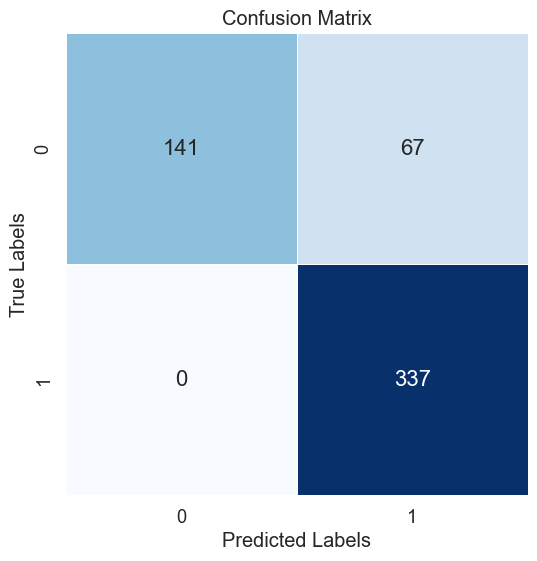

In [55]:
# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 16}, linewidths=0.5, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [56]:
df1=pd.DataFrame({'Actual': y_test, 'Predict': y_pred})
df1

Actual  Predict
482        0        0
65         0        0
926        1        1
481        0        0
23         1        1
...      ...      ...
1170       1        1
243        1        1
1211       0        1
312        1        1
435        0        0

[545 rows x 2 columns]

In [57]:
print("Accuracy Score for Test Dataset is ",model.score(X_test, y_test)*100,"%")
print("Accuracy Score for Train Dataset is",model.score(X_train,y_train)*100,"%")

Accuracy Score for Test Dataset is  87.70642201834863 %
Accuracy Score for Train Dataset is 89.95475113122173 %


## Save the model

In [58]:
with open("mytrainedplacement_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

## Load the Model

In [59]:
with open("mytrainedplacement_model.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)